---
# Examples of 3-D classifications using several well-known discriminant methods with a surface representation of the results
---

In this script, we show the differences in classification performances between four methods; the linear 
discriminant analysis (LDA), the quadratic discriminant analysis (QDA), the Naive Bayes and the Nearest Centroid.

All methods are applied to a dataset generated from a mixture of two 
uniform ellipsoidal distributions. Each one is weighted with its 
<i>a priori</i> class probability $P(C_{i})$:

<blockquote>  $P(\bf{x}) = P(\bf{x}|C_{1}) P(C_{1}) + P(\bf{x}|C_{2}) P(C_{2})$ </blockquote>


The discriminant methods are used to locate the influence zone(s) of each class i over a 
spatial grid. This corresponds to regions where 

<blockquote> $P(\bf{x}|C_{i}) P(C_{i}) > P(\bf{x}|C_{j \ne i}) P(C_{j \ne i})$ </blockquote>

or 

<blockquote> $h_{i}(\bf{x}) > h_{j \ne i}(\bf{x})$ </blockquote>

with the discriminant function $h_{i}(\bf{x})$ defined as

<blockquote>  $h_{i}(\bf{x}) = \ln P(\bf{x}|C_{i}) P(C_{i})$ </blockquote>


## The Gaussian approximation
In what follows, the discriminant functions $h_{i}(\bf{x})$ are defined for gaussian distributions because 
analytical expressions are easier to derive in this scenario and also because gaussian distributions are often
encountered in practice. Nevertheless, those discriminant functions can be used with other types of data distributions. 
This is why we can apply them to a mixture of two uniform ellipsoidal distributions.



## Quadratic Discriminant Analysis 
Using the matrix form of the 2-D gaussian probability distribution function (PDF), we obtain:

<blockquote>  $h_{i}(\bf{x}) =\frac{1}{2}\ln |\Sigma_{i}| -\frac{1}{2}(\bf{x}-\bf{\mu_{i}})^\top \Sigma_{i}^{-1} (\bf{x}-\bf{\mu_{i}}) + \ln P(C_{i})$  </blockquote>

with 

<blockquote>  The observation:   $\bf{x}=[x_{1} x_{2}]^\top$ </blockquote> 

<blockquote>  The origin:   $\bf{\mu_{i}} = [\mu_{1} \mu_{2}]^\top$  </blockquote> 

<blockquote>  The covariance matrix: $\Sigma_{i} = \begin{pmatrix} \sigma_{x_{1}}^2 & \sigma_{x_{1,2}} \\ \sigma_{x_{1,2}} & \sigma_{x_{2}}^2 \end{pmatrix}$ </blockquote>


## Linear Discriminant Analysis 
If we assume the covariance matrices to be identical (<i>homoscedasticity</i>), we have 
 $\Sigma _{i}=\Sigma$. The shared covariance matrix $\Sigma$ is computed as a weighted mixture of the individual ones:

<blockquote>  $\Sigma = \sum_{i=0}^{N} P(C_{i}) \Sigma_{i}$ </blockquote>

The new discriminant equations produce $\bf{linear}$ boundaries and can be simplified to:
    
<blockquote>  $h_{i}(\bf{x}) = \bf{\mu_{i}}^\top \Sigma^{-1} \bf{x} - \frac{1}{2}\bf{\mu_{i}}^\top \Sigma^{-1} \bf{\mu_{i}} + \ln P(C_{i})$  </blockquote>


## Naive Bayes 
If we drop the diagonal elements in the covariance matrices

<blockquote>  $\Sigma_{i} = \begin{pmatrix} \sigma_{x_{1}}^2 & 0 \\ 0 & \sigma_{x_{2}}^2 \end{pmatrix}$ </blockquote>

the discriminant equations produce $\bf{quadratic}$ boundaries and can be simplified to:
    
<blockquote>  $h_{i}(\bf{x}) = -\frac{1}{2}\sum_{j=1}^{2}(\frac{x_{j}-\mu_{i,j}}{\sigma_{i,j}})^2  + \ln P(C_{i})$  </blockquote>


## Nearest Centroid
If we assume each covariance matrix to be isotropic ($\sigma_{x_{1}}=\sigma_{x_{2}}=\sigma$)

<blockquote>  $\Sigma_{i} = \begin{pmatrix} \sigma_{i}^2 & 0 \\ 0 & \sigma_{i}^2 \end{pmatrix}$ </blockquote>

the discriminant equations produce $\bf{linear}$ boundaries and can be simplified to:

<blockquote>  $h_{i}(\bf{x}) = -\frac{\Vert \bf{x}-\bf{\mu_{i}} \Vert^2}{2\sigma_{i}^2} + \ln P(C_{i})$  </blockquote>


In [1]:
print(__doc__)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestCentroid

from skimage.measure import marching_cubes_lewiner

import math

import seaborn as sns
sns.set(color_codes=True)

Automatically created module for IPython interactive environment


# Part I: Functions for dataset generation and 3-D classification.
The following functions are used to generate the datasets and to display the classification results for series of examples.

In [2]:
def generate_dataset(r, Mu, prob_C):
    
    # Number of data points in each cluster
    npts = 5000
    n = ( npts*prob_C).astype(int)

    # --------- Generate uniform ellipsoidal distributions-----
    # N.B. The distributions are spherical when r[i,:] = R
    for i in range(2):
        phi = np.random.uniform(0,2*math.pi, n[i])
        costheta = np.random.uniform(-1,1, n[i])
        u = np.random.uniform(0,1, n[i])

        theta = np.arccos( costheta )
        a =  r[i,0] * np.cbrt( u )
        b =  r[i,1] * np.cbrt( u )
        c =  r[i,2] * np.cbrt( u )

        xi =  Mu[i,0] + a * np.sin( theta) * np.cos( phi )
        yi =  Mu[i,1] + b * np.sin( theta) * np.sin( phi )
        zi =  Mu[i,2] + c * np.cos( theta )

        if (i==0):
            X = np.c_[xi.ravel(), yi.ravel(), zi.ravel()]
            y = np.zeros(n[0])
        else:   
            X = np.r_[X, np.c_[xi.ravel(), yi.ravel(), zi.ravel()]]
            y = np.r_[y, np.ones(n[i])]
            
    return (X,y)

In [3]:
def generate_3D_classification(ax, X, y, prob_C, method, figName, view=[15, -20]):

    # --------- Generate a 3-D spatial grid where the PDF will be evaluated locally --------
    nx, ny, nz = 100, 100, 100
    x_min, x_max = 0., 10.
    y_min, y_max = 0., 10.
    z_min, z_max = 0., 10.    
    xx,  yy,  zz = np.meshgrid(np.linspace( x_min,  x_max,  nx), 
                               np.linspace( y_min,  y_max,  ny),
                               np.linspace( z_min,  z_max,  nz))
    Xgrid = np.c_[ xx.ravel(),  yy.ravel(),  zz.ravel()]

    # Grid spacings
    dx = ( x_max -  x_min)/( nx-1)
    dy = ( y_max -  y_min)/( ny-1)
    dz = ( z_max -  z_min)/( nz-1)


    # ---------- Using a given classifier, get the local probability for class 1 -----------
    method_names = {'QDA', 'LDA', 'NaiveBayes', 'NearestCentroid'}
    if method not in method_names:
        raise ValueError("The method name should be one of %r." % method_names)

    if (method=='QDA'):
        # Quadratic discriminant analysis
        qda = QuadraticDiscriminantAnalysis(store_covariance=True)
        prob = qda.fit(X, y).predict_proba(Xgrid) 
        prob = prob[:,1] # Class 1 probability
        methodName = 'Quadratic Discriminant Analysis'
    elif (method=='LDA'):        
        # Linear discriminant analysis
        lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
        prob = lda.fit(X, y).predict_proba(Xgrid) 
        prob = prob[:,1] # Class 1 probability
        methodName = 'Linear Discriminant Analysis'
    elif (method=='NaiveBayes'):
        # Naive Bayes
        gnb = GaussianNB()
        y_pred = gnb.fit(X, y).predict_proba(Xgrid)
        prob = y_pred.astype(float)
        prob = prob[:,1] # Class 1 probability
        methodName = 'Naive Bayes'
    elif (method=='NearestCentroid'):
        # Nearest centroid
        clf = NearestCentroid()
        y_pred = clf.fit(X, y).predict(Xgrid)
        prob = (y_pred==1).astype(float)  # Class 1 probability
        methodName = 'Nearest Centroid'

    prob = prob.reshape(xx.shape)    
    

    # --------- Display the planar boundary between both ellipsoidal distributions -----

    # Display the data points
    cm_bright = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    ax.scatter( X[:, 0],  X[:, 1],  X[:, 2], s=30, c= y, cmap=cm_bright, edgecolors='k')


    # Display the 3-D boundary separating the two data clusters. The boundary is located where the a posteriori 
    # probabilities for both classes are identical, i.e. P(x|Ci)=0.5
    prob = np.transpose( prob, (1, 0, 2))
    verts, faces, _, _ = marching_cubes_lewiner( prob, 0.5, spacing=( dy,  dx,  dz))
    ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], alpha=0.1, edgecolor='w', linewidth=0.2, antialiased=True,
                    zorder=1)

    ax.view_init(view[0], view[1])

    ax.set_xlim3d( x_min,  x_max)
    ax.set_ylim3d( y_min,  y_max)
    ax.set_zlim3d( z_min,  z_max)
    ax.set_xlabel('$X_{1}$', rotation=0, fontsize=15)
    ax.set_ylabel('$X_{2}$', fontsize=15)
    ax.set_zlabel('$X_{3}$', fontsize=15)
    ax.yaxis.set_label_coords(-0.1,0.5)
    ax.xaxis.set_label_coords(0.5, -0.1)        
    
    
    # Display class a priori probabilities P(Ci)
    if (method=='QDA'):
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.99)
        texte1 = '$\mathbf{\mathcal{R}_{1}}$  \n  $P(w_{1}) = %0.2f$' %  prob_C[0]   
        texte2 = '$\mathbf{\mathcal{R}_{2}}$  \n  $P(w_{2}) = %0.2f$' %  prob_C[1]   
        ax.text(9.0, 0.0, 0., texte1, zdir='y', fontsize=14, bbox=props, color='red', zorder=1)               
        ax.text(0.0, 5.0, 8., texte2, zdir='y', fontsize=14, bbox=props, color='blue', zorder=1)   
 


    fig.tight_layout()
    ax.set_title(methodName, fontsize=20)
    
    plt.savefig(figName + '.png')
    plt.savefig(figName + '.pdf')


# Part II: Various examples of 3-D segmentation for two uniform ellipsoidal distributions.

### Different distributions with the same <i>a priori</i> probability $P(C_{i})=50\%$
This example shows that the QDA and the Naive Bayes methods produce similar results; the influence 
zones have $\bf{quadratic}$ boundaries. The LDA and the Nearest Centroid methods also produce similar results
but with $\bf{linear}$ boundaries.

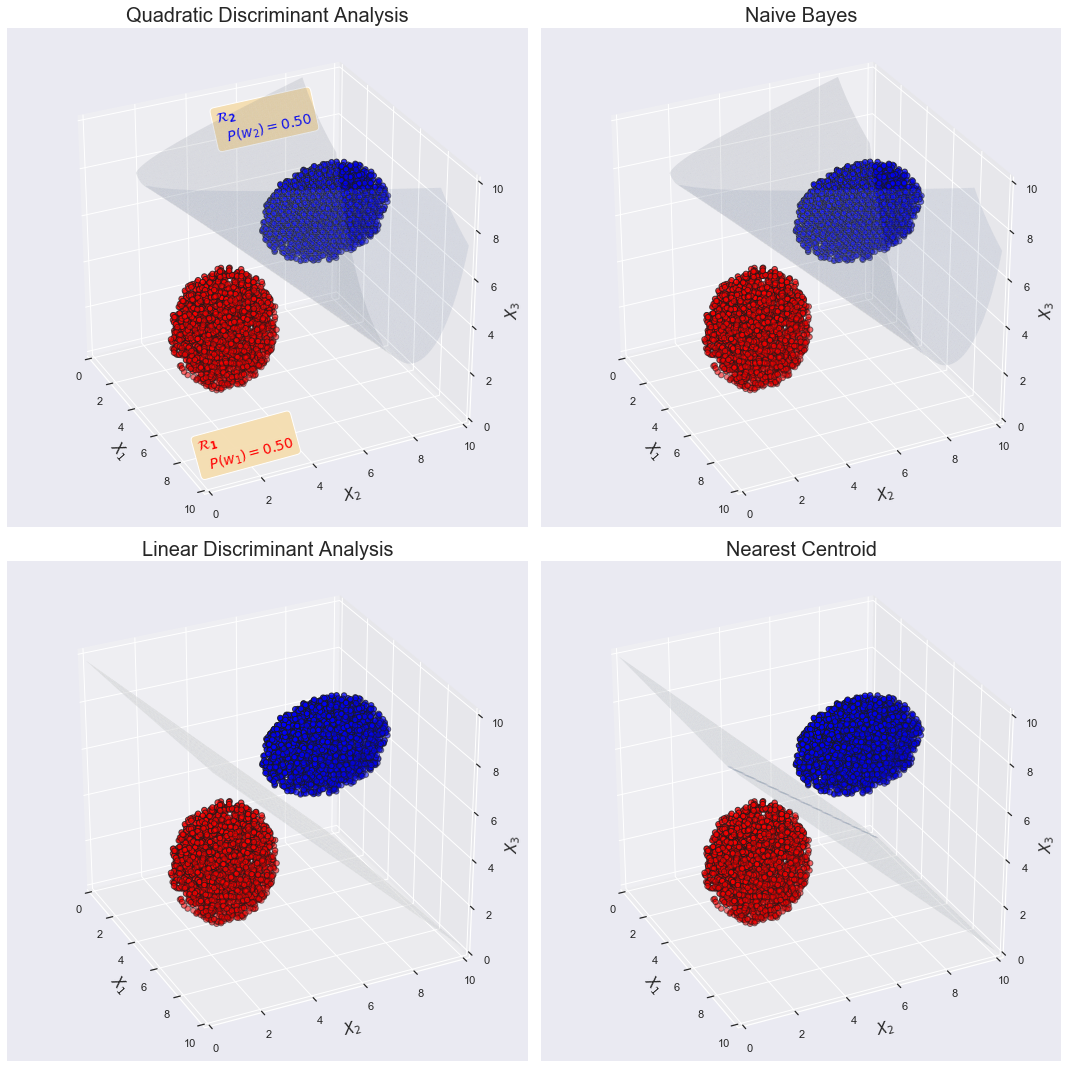

In [4]:
# Used for reproductibility of the results
np.random.seed(42)

# Center of each ellipsoidal data cluster
Mu = np.zeros((2,3))
Mu[0,:] = [5., 3., 3.]
Mu[1,:] = [5., 7., 7.]    

radius = np.zeros((2,3))
radius[0,:] = np.array([1.5, 2., 2.5])
radius[1,:] = np.array([1., 2.5, 2.])

# A priori class probabilities
prob_C = np.array([0.5, 0.5]) 


view = [30, -26]

method_names = ['QDA', 'NaiveBayes', 'LDA', 'NearestCentroid']
figName= '3D_classification_4_methods_1'

fig, axs = plt.subplots(2, 2, figsize = (15,15), subplot_kw={'projection': '3d'}) 
fig.canvas.set_window_title('3D')

(X,y) = generate_dataset(radius, Mu, prob_C)
for k in range(4):
    i = k // 2
    j = k % 2
    generate_3D_classification(axs[i,j], X, y, prob_C, method_names[k], figName, view=view)

plt.show()

### Different distributions with very different <i>a priori</i> probabilities $P(C_{i})$
This example shows that the QDA and the Naive Bayes methods produce once again similar $\bf{quadratic}$ boundaries. 
The LDA and the Nearest Centroid methods produce $\bf{linear}$ boundaries located at different distances from the clusters. 

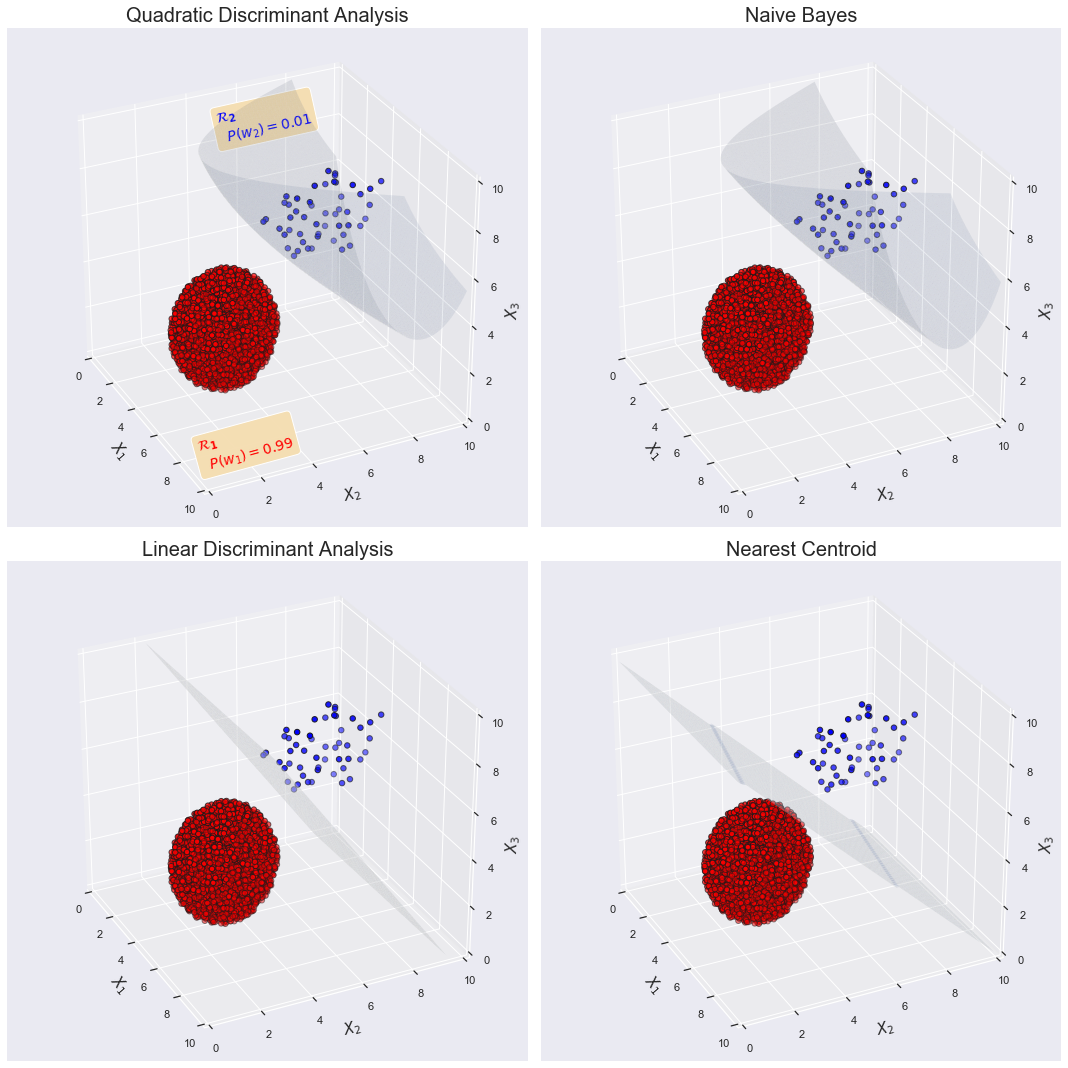

In [5]:
# Used for reproductibility of the results
np.random.seed(42)

# Center of each ellipsoidal data cluster
Mu = np.zeros((2,3))
Mu[0,:] = [5., 3., 3.]
Mu[1,:] = [5., 7., 7.]    

radius = np.zeros((2,3))
radius[0,:] = np.array([1.5, 2., 2.5])
radius[1,:] = np.array([1., 2.5, 2.])

# A priori class probabilities
prob_C = np.array([0.99, 0.01]) 

view = [30, -26]

method_names = ['QDA', 'NaiveBayes', 'LDA', 'NearestCentroid']
figName= '3D_classification_4_methods_2'

fig, axs = plt.subplots(2, 2, figsize = (15,15), subplot_kw={'projection': '3d'}) 
fig.canvas.set_window_title('3D')

(X,y) = generate_dataset(radius, Mu, prob_C)
for k in range(4):
    i = k // 2
    j = k % 2
    generate_3D_classification(axs[i,j], X, y, prob_C, method_names[k], figName, view=view)

plt.show()

### Identical distributions with the same <i>a priori</i> probability $P(C_{i})=50\%$
In all four cases, the boundaries are $\bf{linear}$ but located at different distances from the clusters.

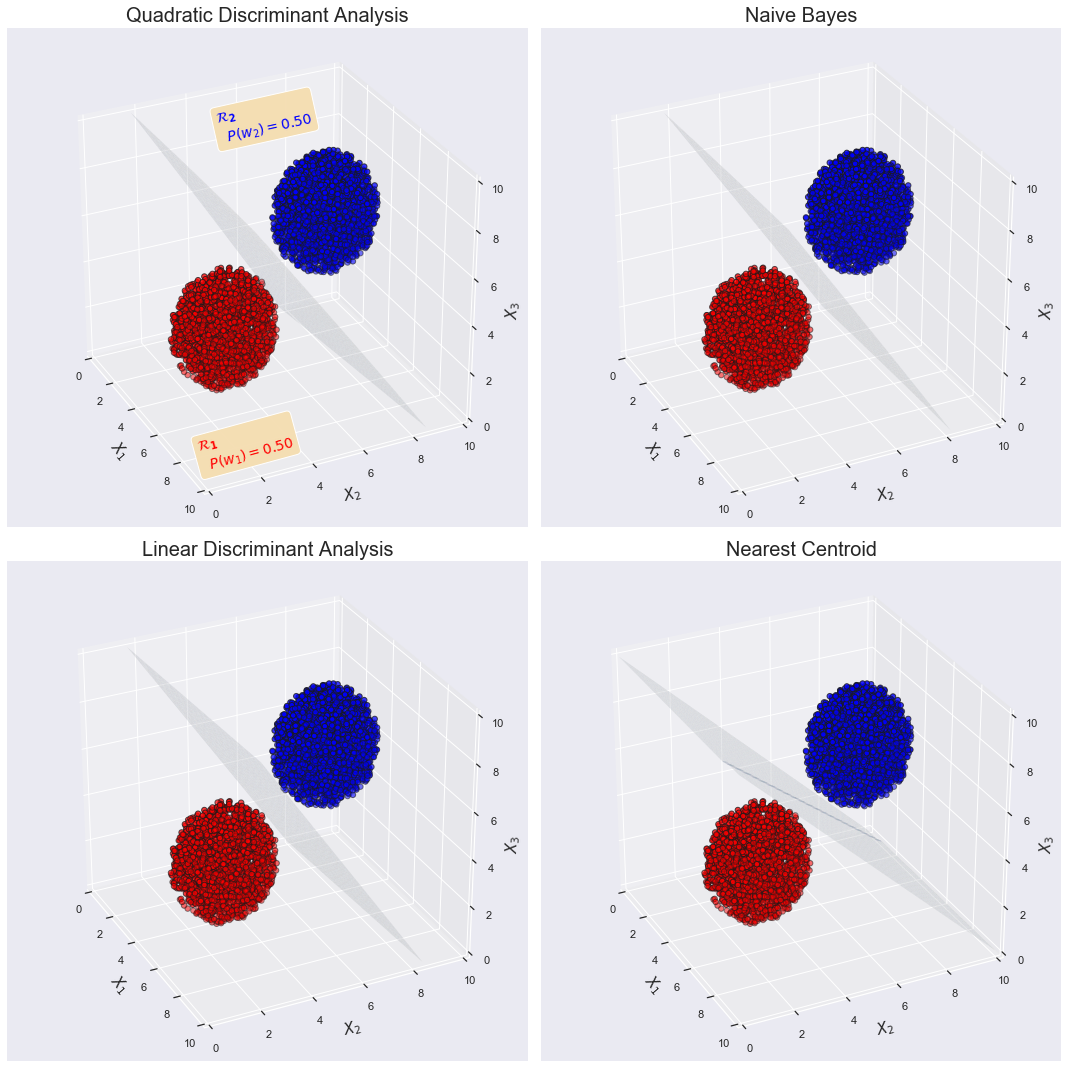

In [6]:
# Used for reproductibility of the results
np.random.seed(42)

# Center of each ellipsoidal data cluster
Mu = np.zeros((2,3))
Mu[0,:] = [5., 3., 3.]
Mu[1,:] = [5., 7., 7.]    

radius = np.zeros((2,3))
radius[0,:] = np.array([1.5, 2., 2.5])
radius[1,:] = np.array([1.5, 2., 2.5])

# A priori class probabilities
prob_C = np.array([0.5, 0.5]) 

view = [30, -26]

method_names = ['QDA', 'NaiveBayes', 'LDA', 'NearestCentroid']
figName= '3D_classification_4_methods_3'

fig, axs = plt.subplots(2, 2, figsize = (15,15), subplot_kw={'projection': '3d'}) 
fig.canvas.set_window_title('3D')

(X,y) = generate_dataset(radius, Mu, prob_C)
for k in range(4):
    i = k // 2
    j = k % 2
    generate_3D_classification(axs[i,j], X, y, prob_C, method_names[k], figName, view=view)

plt.show()

### Identical spherical distributions with the same <i>a priori</i> probability $P(C_{i})=50\%$
In all four cases, the boundaries are $\bf{linear}$ and almost positionned at the same distances from the clusters.

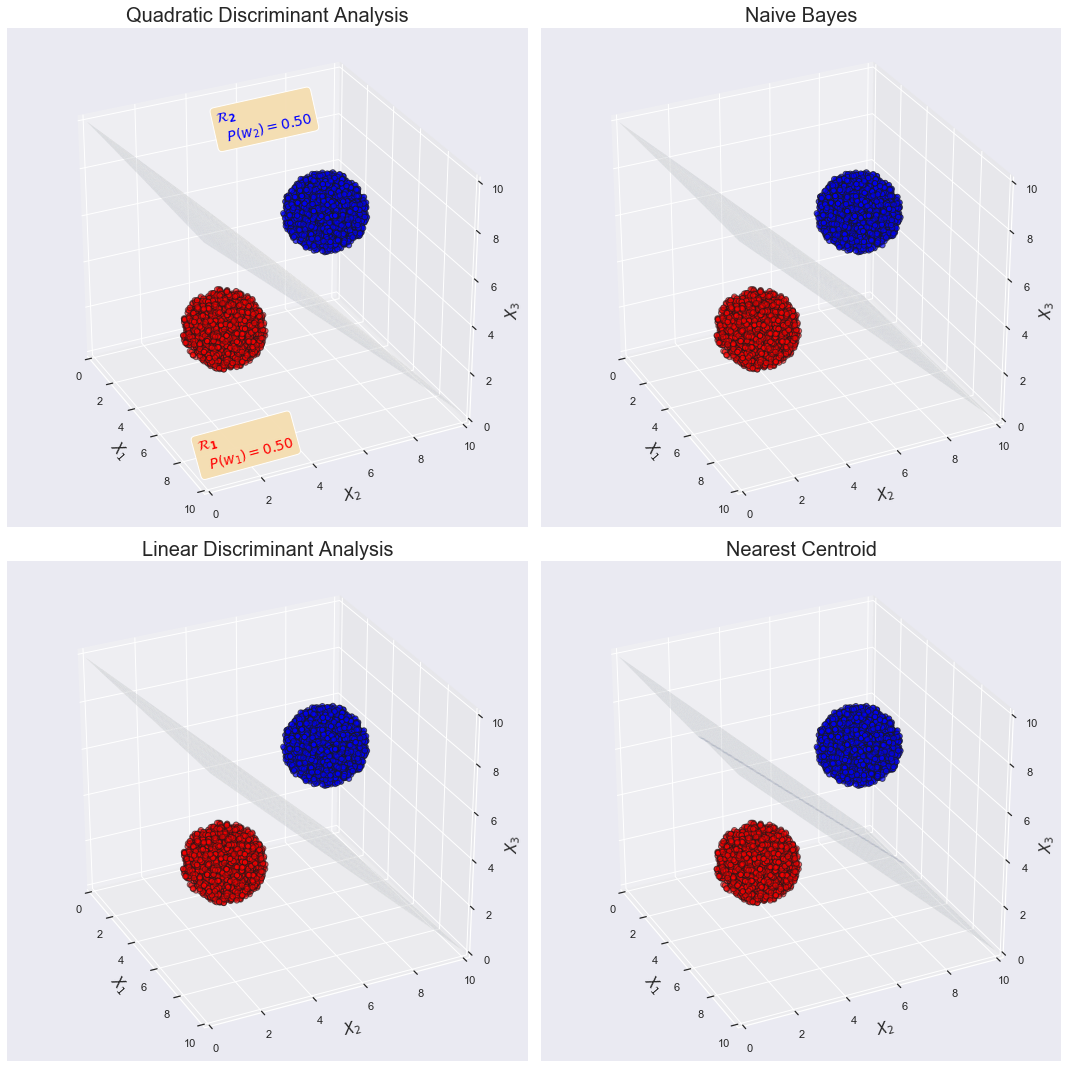

In [7]:
# Used for reproductibility of the results
np.random.seed(42)

# Center of each ellipsoidal data cluster
Mu = np.zeros((2,3))
Mu[0,:] = [5., 3., 3.]
Mu[1,:] = [5., 7., 7.]    

radius = np.zeros((2,3))
radius[0,:] = np.array([1.5, 1.5, 1.5])
radius[1,:] = np.array([1.5, 1.5, 1.5])

# A priori class probabilities
prob_C = np.array([0.5, 0.5]) 



view = [30, -26]

method_names = ['QDA', 'NaiveBayes', 'LDA', 'NearestCentroid']
figName= '3D_classification_4_methods_4'

fig, axs = plt.subplots(2, 2, figsize = (15,15), subplot_kw={'projection': '3d'}) 
fig.canvas.set_window_title('3D')

(X,y) = generate_dataset(radius, Mu, prob_C)
for k in range(4):
    i = k // 2
    j = k % 2
    generate_3D_classification(axs[i,j], X, y, prob_C, method_names[k], figName, view=view)

plt.show()

### Identical spherical distributions with very different <i>a priori</i> probabilities $P(C_{i})$
The boundaries for the QDA and the Naive Bayes methods are slightly $\bf{quadratic}$ whereas those 
for the LDA and the Nearest Centroid are $\bf{linear}$.


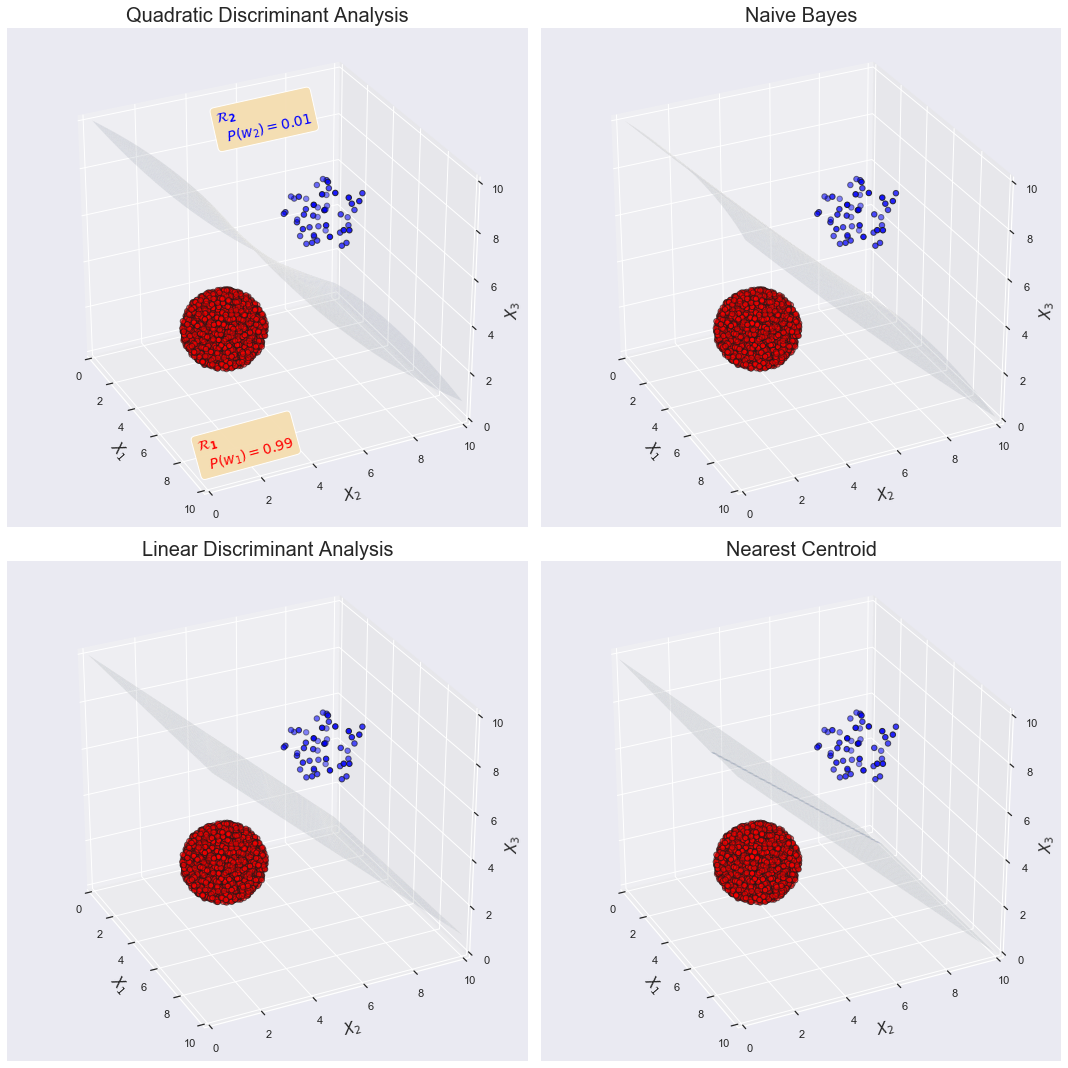

In [8]:
# Used for reproductibility of the results
np.random.seed(42)

# Center of each ellipsoidal data cluster
Mu = np.zeros((2,3))
Mu[0,:] = [5., 3., 3.]
Mu[1,:] = [5., 7., 7.]    

radius = np.zeros((2,3))
radius[0,:] = np.array([1.5, 1.5, 1.5])
radius[1,:] = np.array([1.5, 1.5, 1.5])
#radius[1,:] = np.array([1., 2.5, 2.])

# A priori class probabilities
prob_C = np.array([0.99, 0.01]) 


view = [30, -26]

method_names = ['QDA', 'NaiveBayes', 'LDA', 'NearestCentroid']
figName= '3D_classification_4_methods_5'

fig, axs = plt.subplots(2, 2, figsize = (15,15), subplot_kw={'projection': '3d'}) 
fig.canvas.set_window_title('3D')

(X,y) = generate_dataset(radius, Mu, prob_C)
for k in range(4):
    i = k // 2
    j = k % 2
    generate_3D_classification(axs[i,j], X, y, prob_C, method_names[k], figName, view=view)

plt.show()

### Superposed spherical and ellipsoidal distributions with the same <i>a priori</i> probability $P(C_{i})=50\%$
The boundaries for the QDA and the Naive Bayes methods are identical whereas those 
for the LDA and the Nearest Centroid are oriented differently in space.

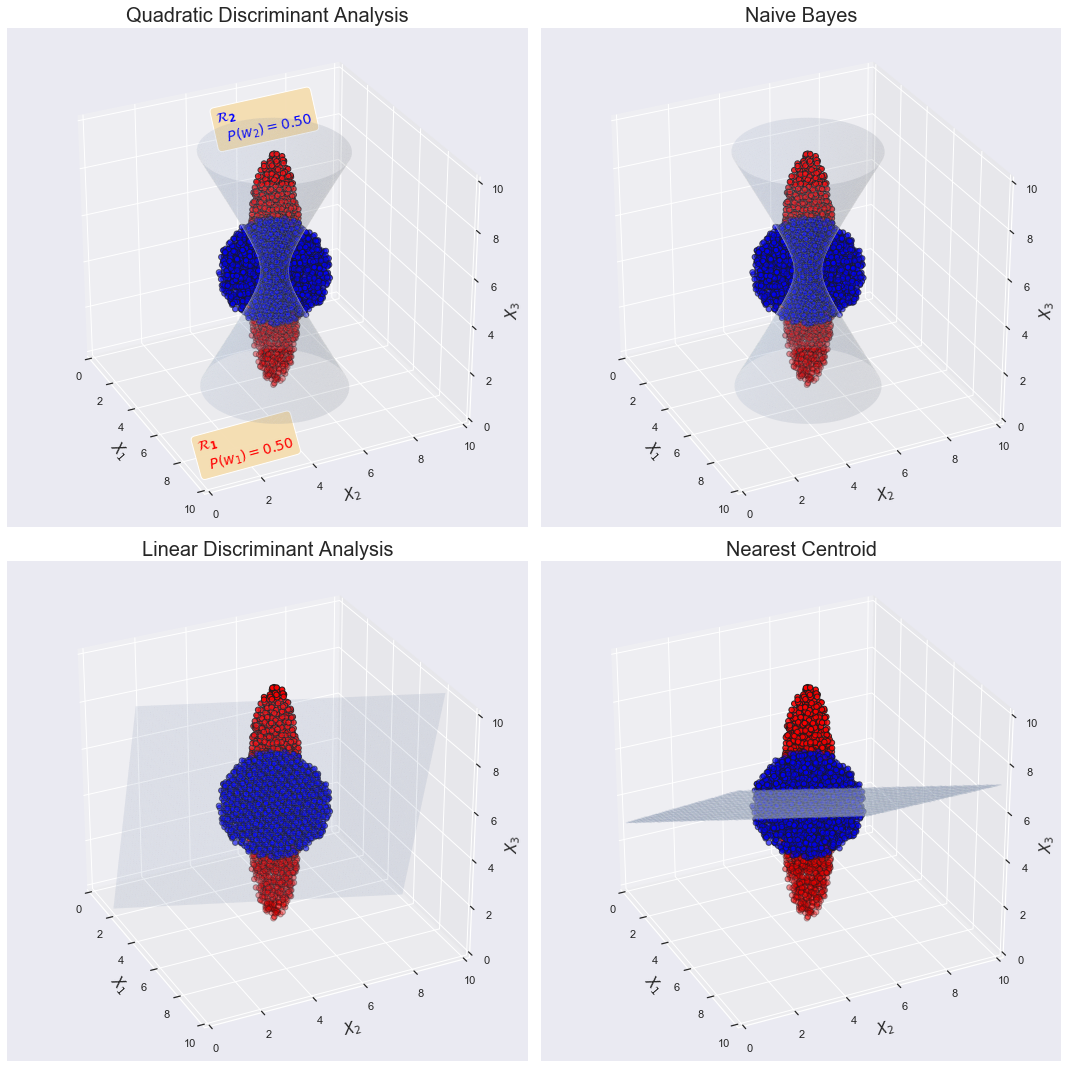

In [9]:
# Used for reproductibility of the results
np.random.seed(42)

# Center of each ellipsoidal data cluster
Mu = np.zeros((2,3))
Mu[0,:] = [5., 5., 5.]
Mu[1,:] = [5., 5., 5.]    

radius = np.zeros((2,3))
radius[0,:] = np.array([1., 1., 5.])
radius[1,:] = np.array([2., 2., 2.])

# A priori class probabilities
prob_C = np.array([0.5, 0.5]) 


view = [30, -26]

method_names = ['QDA', 'NaiveBayes', 'LDA', 'NearestCentroid']
figName= '3D_classification_4_methods_6'

fig, axs = plt.subplots(2, 2, figsize = (15,15), subplot_kw={'projection': '3d'}) 
fig.canvas.set_window_title('3D')

(X,y) = generate_dataset(radius, Mu, prob_C)
for k in range(4):
    i = k // 2
    j = k % 2
    generate_3D_classification(axs[i,j], X, y, prob_C, method_names[k], figName, view=view)

plt.show()

### Touching spherical and ellipsoidal distributions with the same <i>a priori</i> probability $P(C_{i})=50\%$
Both quadratic boundaries are quite similar as well as both linear boundaries.


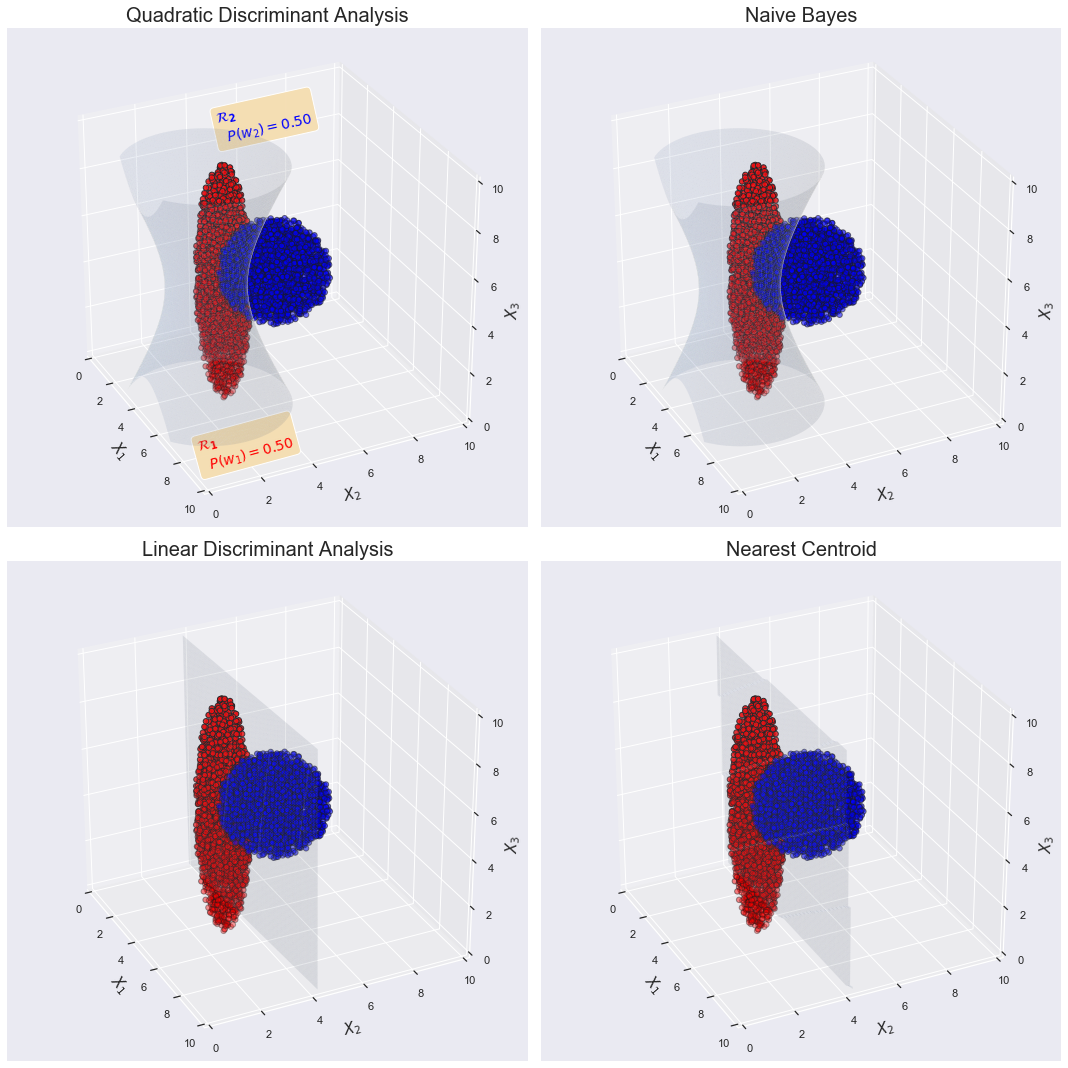

In [10]:
# Used for reproductibility of the results
np.random.seed(42)

# Center of each ellipsoidal data cluster
Mu = np.zeros((2,3))
Mu[0,:] = [5., 3., 5.]
Mu[1,:] = [5., 5., 5.]    

radius = np.zeros((2,3))
radius[0,:] = np.array([1., 1., 5.])
radius[1,:] = np.array([2., 2., 2.])

# A priori class probabilities
prob_C = np.array([0.5, 0.5]) 


view = [30, -26]

method_names = ['QDA', 'NaiveBayes', 'LDA', 'NearestCentroid']
figName= '3D_classification_4_methods_7'

fig, axs = plt.subplots(2, 2, figsize = (15,15), subplot_kw={'projection': '3d'}) 
fig.canvas.set_window_title('3D')

(X,y) = generate_dataset(radius, Mu, prob_C)
for k in range(4):
    i = k // 2
    j = k % 2
    generate_3D_classification(axs[i,j], X, y, prob_C, method_names[k], figName, view=view)

plt.show()

### Separated spherical and ellipsoidal distributions with the same <i>a priori</i> probability $P(C_{i})=50\%$
Both quadratic boundaries are quite similar as well as both linear boundaries.


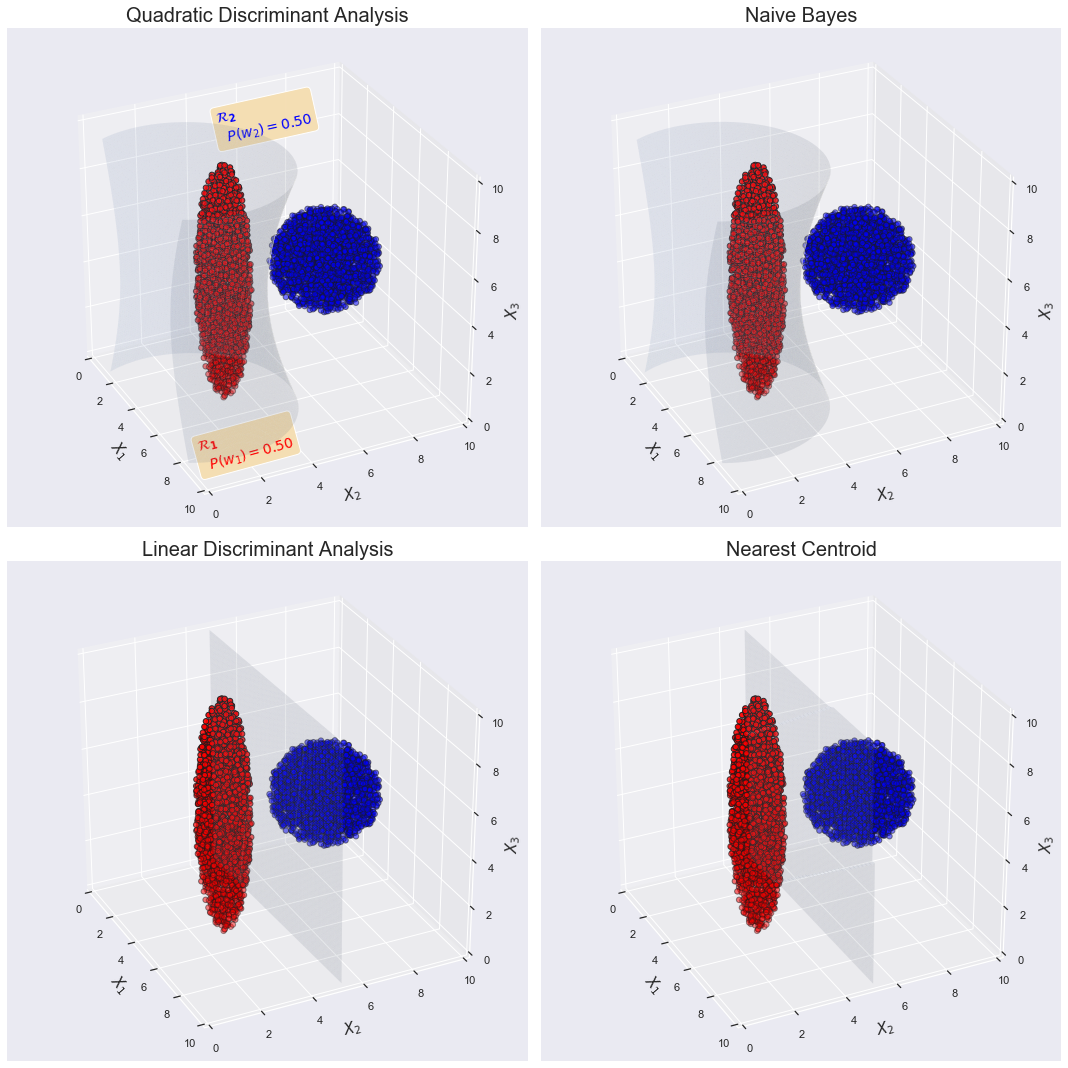

In [11]:
# Used for reproductibility of the results
np.random.seed(42)

# Center of each ellipsoidal data cluster
Mu = np.zeros((2,3))
Mu[0,:] = [5., 3., 5.]
Mu[1,:] = [5., 7., 5.]    

radius = np.zeros((2,3))
radius[0,:] = np.array([1., 1., 5.])
radius[1,:] = np.array([2., 2., 2.])

# A priori class probabilities
prob_C = np.array([0.5, 0.5]) 


view = [30, -26]

method_names = ['QDA', 'NaiveBayes', 'LDA', 'NearestCentroid']
figName= '3D_classification_4_methods_8'

fig, axs = plt.subplots(2, 2, figsize = (15,15), subplot_kw={'projection': '3d'}) 
fig.canvas.set_window_title('3D')

(X,y) = generate_dataset(radius, Mu, prob_C)
for k in range(4):
    i = k // 2
    j = k % 2
    generate_3D_classification(axs[i,j], X, y, prob_C, method_names[k], figName, view=view)

plt.show()